In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Thu Jan 29 04:40:24 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 33%   29C    P8              22W / 260W |   2118MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = '../../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)
df.rename(columns= {'DEL': 'IMAGE'}, inplace = True)

In [6]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

In [7]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')


## Setup Input Transformations

In [9]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['IMAGE', 'SEGM'], spatial_size=PATCH_SIZE, mode=('reflect','reflect'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['IMAGE', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['IMAGE', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['IMAGE', 'SEGM'])
])

val_transforms = Compose([
     LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['IMAGE'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE']),
    Orientationd(keys=['IMAGE'], axcodes='RAS'),
    Spacingd(keys=['IMAGE'], pixdim=SPACING, mode=('bilinear'), padding_mode=('reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [10]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-Net/monai_cache'


In [11]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [12]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [13]:
test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Check Input Data

torch.Size([2, 1, 64, 64, 32])
image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.3563060760498047


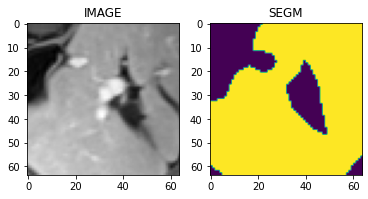

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.6016665697097778


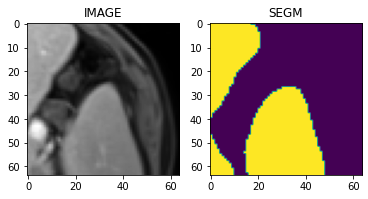

In [14]:
check_ds = monai.data.Dataset(data=train_data_dict[:1], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[:1], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image, label = (check_data['IMAGE'][i][0], check_data['SEGM'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//2
    
    plt.figure('check', (6, 3))
    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.show()

## Create Segmentation Model (U-net)

In [15]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=1, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            #channels=(64, 128, 256, 512),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):
        images, labels = batch["IMAGE"], batch["SEGM"]
        #print(batch['ACCESSION_ID'])
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,1,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        images = batch["IMAGE"]
        labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [16]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,1,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       7,890
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,187,921
Trainable params: 1,187,921
Non-trainable params: 0
Total mult-adds (G): 1.67
Input size (MB): 0.52
Forward/backward pass size (MB): 45.22
Params size (MB): 4.75
Estimated Total Size (MB):

## Model Training

In [17]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-Net'

In [23]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit ch

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


## Model Testing

In [24]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=1060-val_loss=0.07.ckpt')

In [25]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [25]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        if keep:
            dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
        else:
                
            # Calculate Dice on the raw output
            dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            
            
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_results = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)


            x = test_data['IMAGE'].to(device)
            y = test_data['SEGM'].cpu()


            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 3, 1)
                plt.title('IMAGE')
                plt.imshow(x[0,0,:,:,slice_num], cmap='gray')
                plt.subplot(1, 3, 2)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])
                plt.subplot(1, 3, 3)
                plt.title('PRED')
                plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['IMAGE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['IMAGE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['IMAGE_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path = os.path.join(RESULTS_PATH,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path))

                df_eval['SEGM_RESULTS'] = output_path
                output_results.append(output_path)

                write_nifti(argmax.cpu()[0, 0,...].numpy(), output_path,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_results    
    return df_eval


In [26]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    

            x = test_data['IMAGE'].to(device)
            y = test_data['SEGM'].cpu()

            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:

                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 3, 1)
                plt.title('IMAGE')
                plt.imshow(x[0,0,:,:,slice_num], cmap='gray')
 
                plt.subplot(1, 3, 2)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 3, 3)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['IMAGE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['IMAGE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['IMAGE_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [29]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET'

0it [00:00, ?it/s]

torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9640887379646301
1.4142135623730951
0.5523763502340301
torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9640976786613464
1.4142135623730951
0.5455801774556736
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])


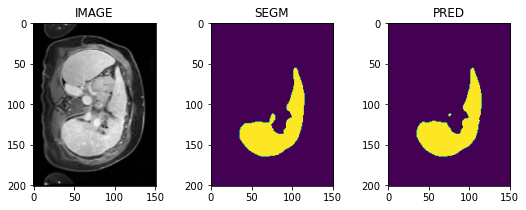

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E100998852_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.965739369392395
51.02253988231928
4.924326830604553
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9756052494049072
1.4142135623730951
0.4393821242875882
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


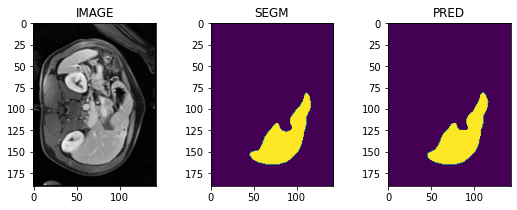

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/12370686_T1_DEL_REG_segm.nii.gz
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.9623621106147766
31.89043743820395
2.6301506800439722
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.968238353729248
1.4142135623730951
0.47890464496780855
torch.Size([1, 2, 220, 177, 120])
torch.Size([1, 220, 177, 120])


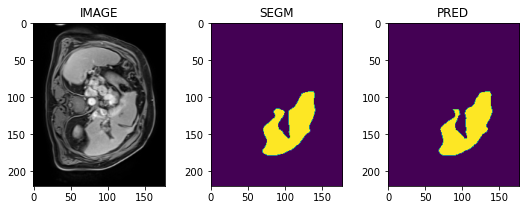

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E104184251_T1_DEL_REG_segm.nii.gz
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.9572579264640808
42.34383071948026
4.153449755252667
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.9701319336891174
1.4142135623730951
0.5340810487015285
torch.Size([1, 2, 230, 230, 144])
torch.Size([1, 230, 230, 144])


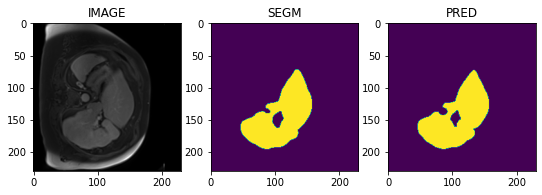

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E100353838_T1_DEL_REG_segm.nii.gz
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.937119722366333
63.66317616958802
16.05095028858798
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.9613845348358154
2.23606797749979
0.597843332922494
torch.Size([1, 2, 210, 158, 95])
torch.Size([1, 210, 158, 95])


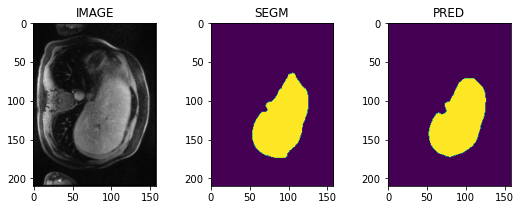

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/11655071_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9563689231872559
1.4142135623730951
1.0476438674078423
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.958236038684845
1.4142135623730951
0.5449807186798354
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


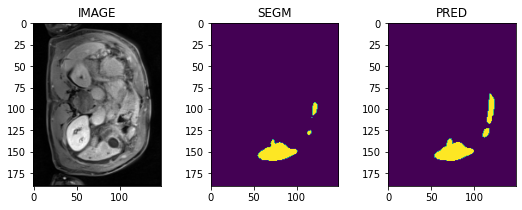

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E105258820_T1_DEL_REG_segm.nii.gz
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.866807222366333
66.17212395937038
13.71699180970641
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.9462001919746399
3.605551275463989
1.0849600130150518
torch.Size([1, 2, 180, 169, 140])
torch.Size([1, 180, 169, 140])


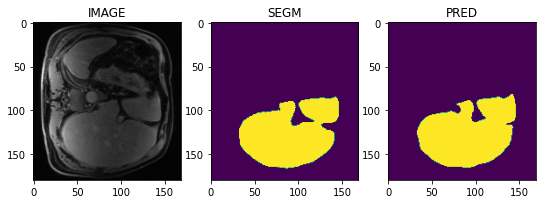

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/10782833_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9740873575210571
1.4142135623730951
1.2177508480719272
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9754389524459839
1.4142135623730951
0.40210116201225266
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


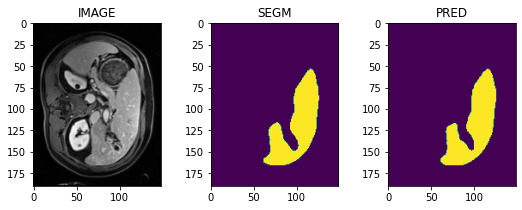

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E105047582_T1_DEL_REG_segm.nii.gz
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.932924211025238
61.40480423867263
7.284931757214559
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.9541270732879639
2.0
0.6785593559639697
torch.Size([1, 2, 200, 156, 120])
torch.Size([1, 200, 156, 120])


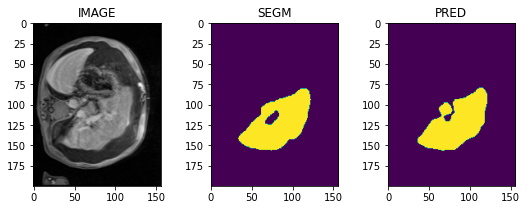

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E100559269_T1_DEL_REG_segm.nii.gz
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.8521625399589539
52.24940191045253
8.647169167487627
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.9344335794448853
4.123105625617661
0.9022225169573912
torch.Size([1, 2, 180, 147, 132])
torch.Size([1, 180, 147, 132])


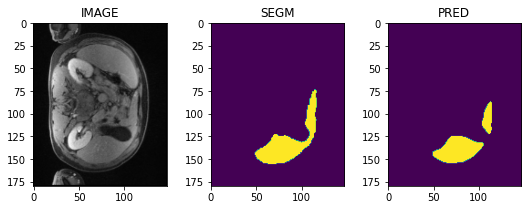

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/11157922_T1_DEL_REG_segm.nii.gz
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.9424685835838318
75.6042326857432
13.265680478104183
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.967956006526947
1.4142135623730951
0.5598171718826304
torch.Size([1, 2, 203, 172, 116])
torch.Size([1, 203, 172, 116])


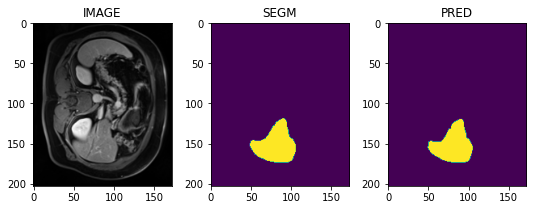

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E103977998_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9603230953216553
2.23606797749979
0.6623823855346598
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9603230953216553
2.23606797749979
0.6623823855346598
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


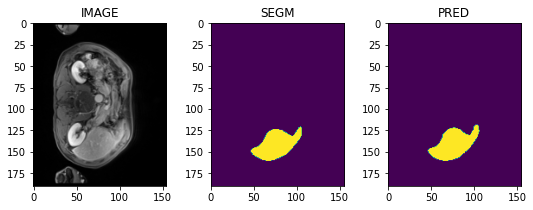

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E106605970_T1_DEL_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9266389608383179
39.824615503479755
6.122684161670747
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9511972665786743
5.656854249492381
0.6907315070176461
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


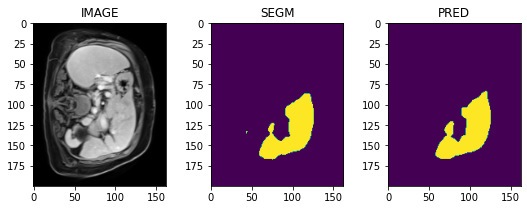

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E101166449_T1_DEL_REG_segm.nii.gz
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.8814475536346436
93.32470094395916
33.81767856398123
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.9690441489219666
1.7320508075688772
0.5085388747932802
torch.Size([1, 2, 221, 221, 110])
torch.Size([1, 221, 221, 110])


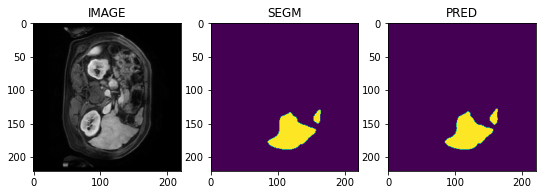

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E101693803_T1_DEL_REG_segm.nii.gz
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.9595425724983215
2.449489742783178
1.9804328699646945
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.9638970494270325
1.4142135623730951
0.5347248983936276
torch.Size([1, 2, 205, 160, 120])
torch.Size([1, 205, 160, 120])


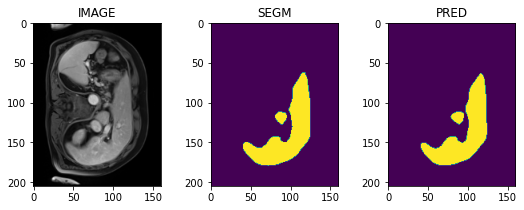

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E100488381_T1_DEL_REG_segm.nii.gz
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.9643584489822388
2.23606797749979
1.6046643239470118
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.9652351140975952
2.23606797749979
0.5831628072926521
torch.Size([1, 2, 225, 176, 132])
torch.Size([1, 225, 176, 132])


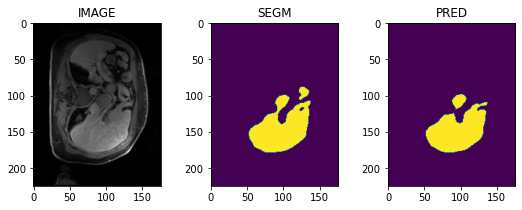

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E101446184_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9594059586524963
2.23606797749979
1.5869569617789285
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9611268639564514
2.0
0.5745972319642547
torch.Size([1, 2, 190, 127, 108])
torch.Size([1, 190, 127, 108])


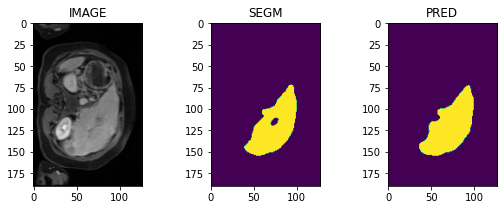

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/12132879_T1_DEL_REG_segm.nii.gz
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.975307285785675
1.0
0.42405354552204466
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.975307285785675
1.0
0.42405354552204466
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])


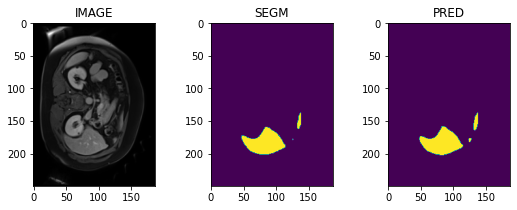

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E100207522_T1_DEL_REG_segm.nii.gz
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9500724077224731
61.69278726074872
7.1697214395120135
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9670397639274597
1.7320508075688772
0.5795568790505955
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])


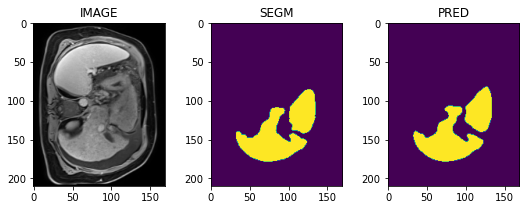

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E104350920_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.913772702217102
38.79432948254165
5.797215644286479
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9398633241653442
4.123105625617661
1.1182341054541467
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


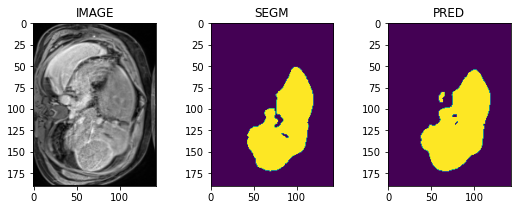

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E103442524_T1_DEL_REG_segm.nii.gz
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.922187089920044
65.82590673328944
10.617838088205785
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.9693944454193115
2.0
0.6218345550305296
torch.Size([1, 2, 210, 210, 132])
torch.Size([1, 210, 210, 132])


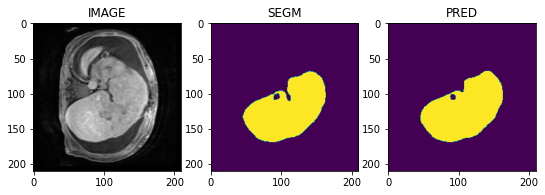

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E100354995_T1_DEL_REG_segm.nii.gz
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.9684295058250427
2.23606797749979
1.962888811673252
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.9696276187896729
1.7320508075688772
0.5503934420141885
torch.Size([1, 2, 200, 157, 120])
torch.Size([1, 200, 157, 120])


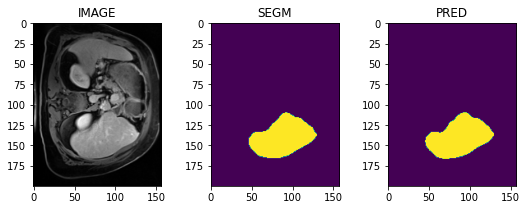

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/12169194_T1_DEL_REG_segm.nii.gz
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.8523504137992859
66.57251677141306
17.367143013634564
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.9677603840827942
1.4142135623730951
0.5245370355857076
torch.Size([1, 2, 191, 191, 88])
torch.Size([1, 191, 191, 88])


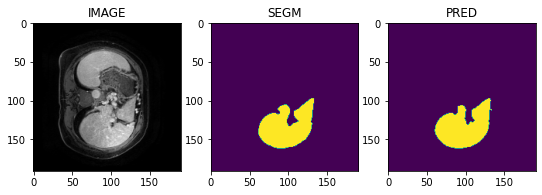

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/9464709_T1_DEL_REG_segm.nii.gz
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.854293167591095
113.97126828826875
35.50677877242062
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.9685822129249573
1.4142135623730951
0.5552877916088051
torch.Size([1, 2, 221, 221, 144])
torch.Size([1, 221, 221, 144])


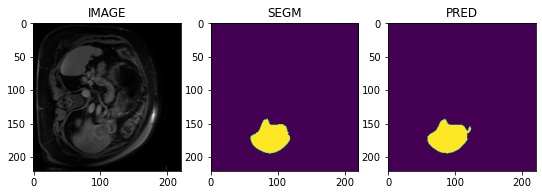

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E102885531_T1_DEL_REG_segm.nii.gz
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.8686594367027283
44.384682042344295
8.00853397322007
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.8686822652816772
44.33339563488749
7.991707665363286
torch.Size([1, 2, 200, 163, 108])
torch.Size([1, 200, 163, 108])


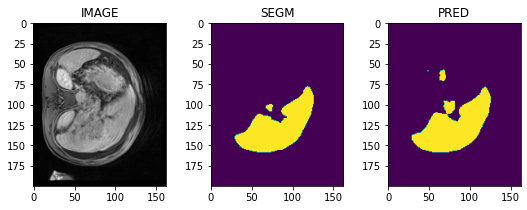

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E106731917_T1_DEL_REG_segm.nii.gz
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.924512505531311
79.7370679169983
10.202619569290656
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.9490389227867126
5.830951894845301
0.694876077246729
torch.Size([1, 2, 211, 211, 131])
torch.Size([1, 211, 211, 131])


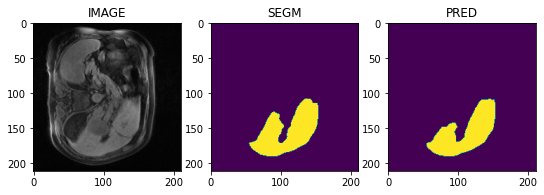

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E105877173_T1_DEL_REG_segm.nii.gz
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.9642710089683533
1.7320508075688772
1.2181957151339229
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.965050995349884
1.7320508075688772
0.5504147582821899
torch.Size([1, 2, 175, 143, 108])
torch.Size([1, 175, 143, 108])


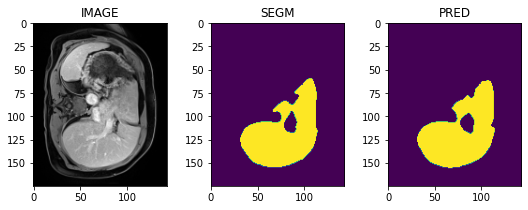

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E106096969_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.9502758383750916
2.8284271247461903
1.4531259379524748
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.9520831108093262
2.23606797749979
0.7510321354744665
torch.Size([1, 2, 190, 184, 120])
torch.Size([1, 190, 184, 120])


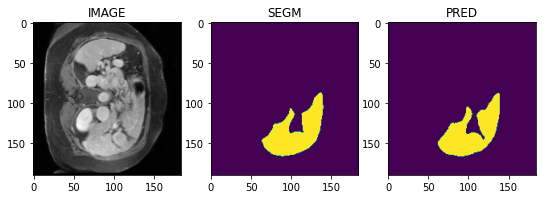

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/11571840_T1_DEL_REG_segm.nii.gz
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.9593794345855713
5.0990195135927845
2.933259089691817
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.9633397459983826
2.0
0.6024621433511513
torch.Size([1, 2, 220, 165, 131])
torch.Size([1, 220, 165, 131])


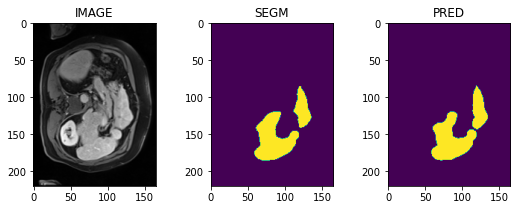

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E101753253_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9775063991546631
1.0
0.5777079838648214
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9776818156242371
1.0
0.38499123330803525
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


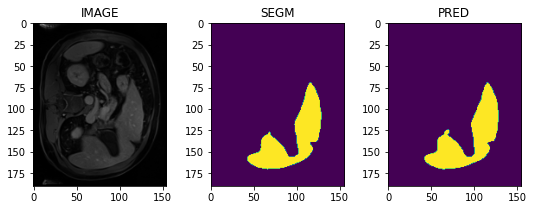

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E103922902_T1_DEL_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9660359621047974
1.7320508075688772
0.6145501220181548
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9660359621047974
1.7320508075688772
0.6145501220181548
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


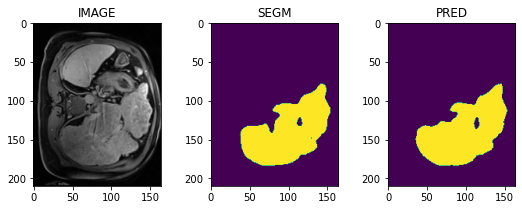

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E101453378_T1_DEL_REG_segm.nii.gz
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.9465732574462891
41.50903516103452
9.826568553189555
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.9668238162994385
2.0
0.5748280263613637
torch.Size([1, 2, 180, 146, 102])
torch.Size([1, 180, 146, 102])


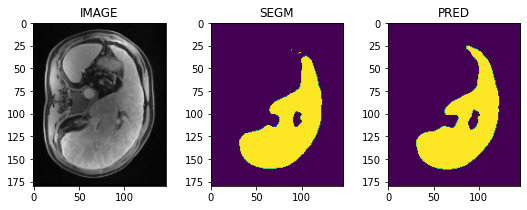

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/11397044_T1_DEL_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.914948582649231
38.65229618017538
6.438638212862939
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9670381546020508
2.0
0.5427455004013129
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


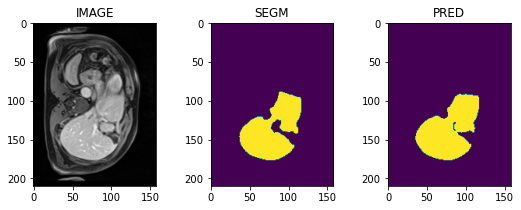

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/12922235_T1_DEL_REG_segm.nii.gz
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.9594775438308716
5.0990195135927845
2.572196150706838
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.9635464549064636
2.0
0.6352941826312819
torch.Size([1, 2, 185, 151, 120])
torch.Size([1, 185, 151, 120])


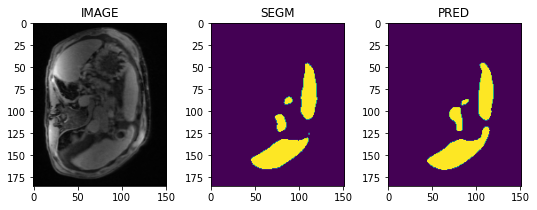

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/10939089_T1_DEL_REG_segm.nii.gz
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9775977730751038
1.0
0.3805546969273319
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9775977730751038
1.0
0.3805546969273319
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])


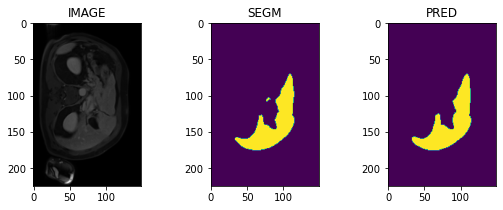

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/12957044_T1_DEL_REG_segm.nii.gz
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.968567430973053
2.0
0.5720975837986161
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.968567430973053
2.0
0.5720975837986161
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])


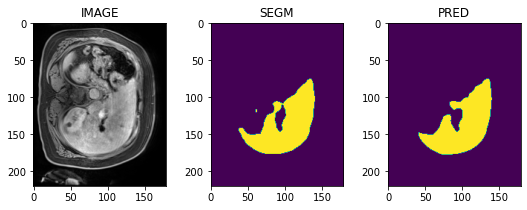

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E107891018_T1_DEL_REG_segm.nii.gz
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.9710635542869568
1.4142135623730951
0.49706468046125185
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.9710635542869568
1.4142135623730951
0.49706468046125185
torch.Size([1, 2, 201, 151, 132])
torch.Size([1, 201, 151, 132])


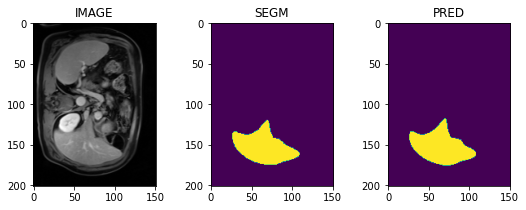

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E104332583_T1_DEL_REG_segm.nii.gz
torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])
torch.Size([1, 2, 220, 165, 144])
0.9630009531974792
55.282897974962474
4.264776312498985
torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])
torch.Size([1, 2, 220, 165, 144])
0.9708825945854187
1.7320508075688772
0.5717706131863455
torch.Size([1, 2, 220, 165, 144])
torch.Size([1, 220, 165, 144])


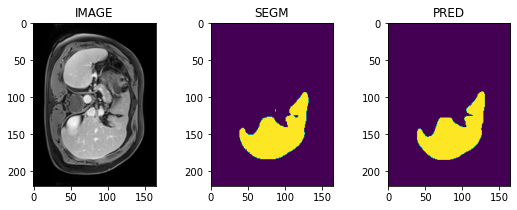

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E101547088_T1_DEL_REG_segm.nii.gz
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.9505160450935364
67.18407540755643
8.937807424070488
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.9753283858299255
1.4142135623730951
0.41295028490309027
torch.Size([1, 2, 195, 147, 139])
torch.Size([1, 195, 147, 139])


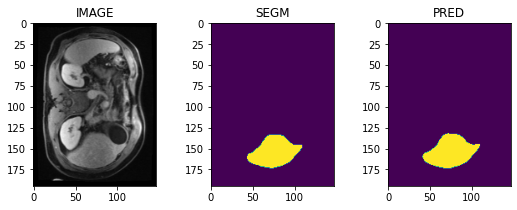

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/11524268_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9690290689468384
1.4142135623730951
0.5361251294957681
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9691212773323059
1.4142135623730951
0.4885811864573568
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


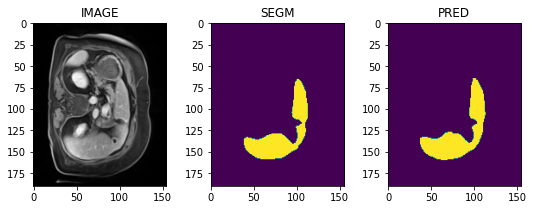

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E106458466_T1_DEL_REG_segm.nii.gz
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.9483677744865417
3.1622776601683795
2.254971934026348
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.9503311514854431
2.23606797749979
0.7603026094327748
torch.Size([1, 2, 197, 160, 96])
torch.Size([1, 197, 160, 96])


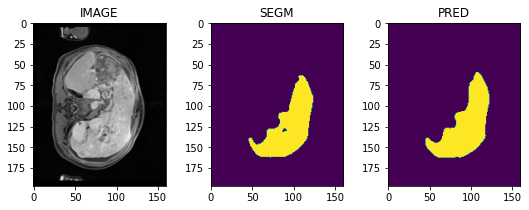

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E107235152_T1_DEL_REG_segm.nii.gz
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.9619626402854919
2.0
1.1939912741529386
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.9627538919448853
2.0
0.5916967019888927
torch.Size([1, 2, 201, 201, 123])
torch.Size([1, 201, 201, 123])


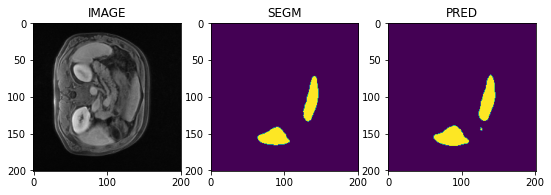

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E105198762_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.7345492839813232
66.88796603276258
18.014194330785596
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.7347803115844727
66.94027188471824
17.96591271532943
torch.Size([1, 2, 190, 164, 144])
torch.Size([1, 190, 164, 144])


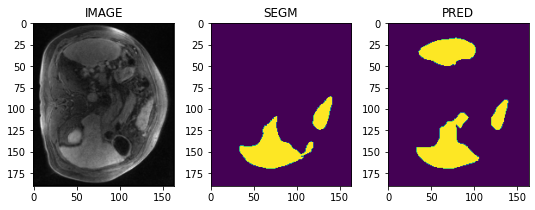

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/11148247_T1_DEL_REG_segm.nii.gz
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.9512888789176941
63.448404132477144
5.023454851898508
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.963324785232544
2.23606797749979
0.6540835465553394
torch.Size([1, 2, 196, 192, 120])
torch.Size([1, 196, 192, 120])


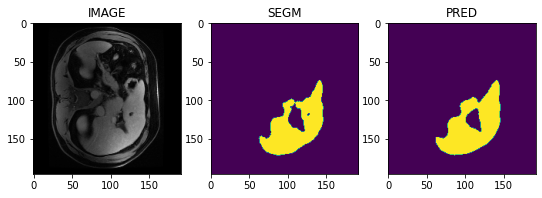

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E106751045_T1_DEL_REG_segm.nii.gz
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.9083037972450256
52.278102490430925
7.691921346792561
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.9444190263748169
3.0
0.9006172024892247
torch.Size([1, 2, 186, 186, 92])
torch.Size([1, 186, 186, 92])


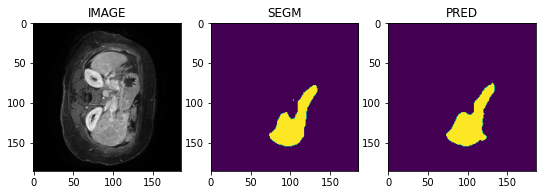

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/9648994_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.8970450162887573
83.50598776901046
16.618264028645203
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.9722868800163269
1.4142135623730951
0.4947194974114584
torch.Size([1, 2, 190, 148, 142])
torch.Size([1, 190, 148, 142])


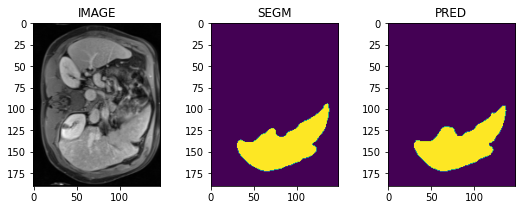

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E102928841_T1_DEL_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.95295250415802
3.0
0.8491761247923922
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9529807567596436
3.0
0.7969004997640996
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


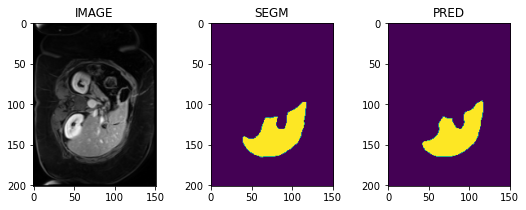

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E105426183_T1_DEL_REG_segm.nii.gz
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.8777023553848267
79.3164547645931
18.0081757666636
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.9627630114555359
2.23606797749979
0.620098123458641
torch.Size([1, 2, 200, 163, 116])
torch.Size([1, 200, 163, 116])


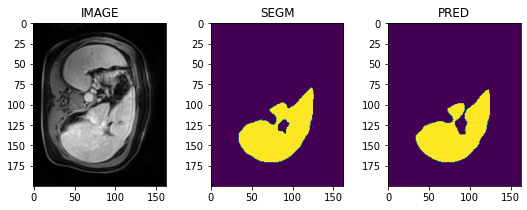

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E100142484_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.974327802658081
1.4142135623730951
0.8381003085179539
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9751970767974854
1.4142135623730951
0.5169563922850192
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


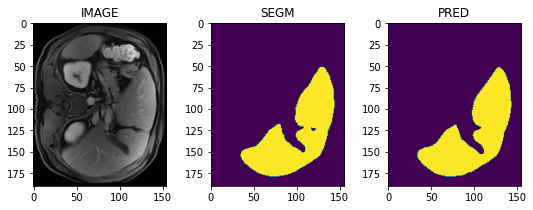

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E105829099_T1_DEL_REG_segm.nii.gz
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.6946384906768799
52.92447448959697
16.2213985618364
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.6946407556533813
52.92447448959697
16.220063058192405
torch.Size([1, 2, 201, 201, 92])
torch.Size([1, 201, 201, 92])


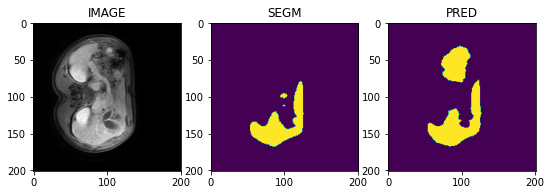

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/9586289_T1_DEL_REG_segm.nii.gz
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.7159073352813721
47.265209192385896
11.912080828652535
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.7172609567642212
47.16990566028302
11.469611956716259
torch.Size([1, 2, 170, 133, 108])
torch.Size([1, 170, 133, 108])


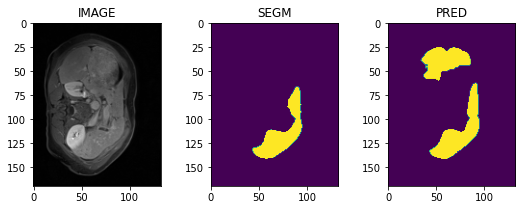

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E107156072_T1_DEL_REG_segm.nii.gz
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9426264762878418
70.49822692805827
8.261983078338755
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9713664054870605
1.7320508075688772
0.5313961397619028
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])


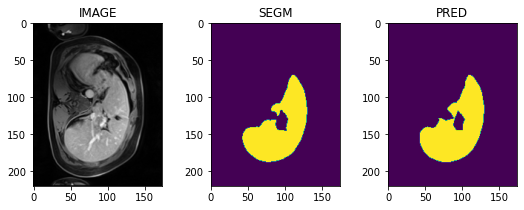

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E104998309_T1_DEL_REG_segm.nii.gz
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9387528896331787
76.93341230396135
12.42247401609327
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9729227423667908
1.4142135623730951
0.5333483284814536
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])


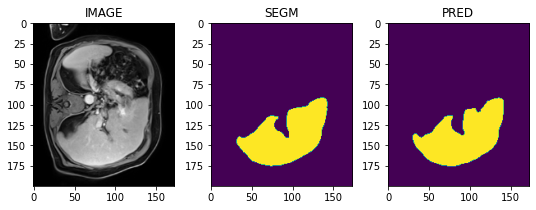

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E105615985_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9631057977676392
48.641546028061235
4.160002680509021
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9734989404678345
1.4142135623730951
0.47779932857929674
torch.Size([1, 2, 190, 149, 132])
torch.Size([1, 190, 149, 132])


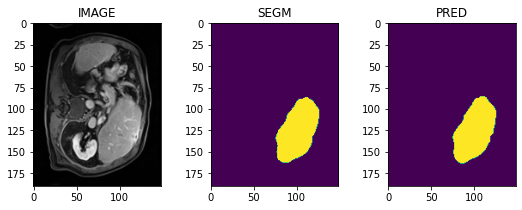

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/12916368_T1_DEL_REG_segm.nii.gz
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.9369454383850098
87.24104538575865
15.616298260649593
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.9689471125602722
2.0
0.7925314381796231
torch.Size([1, 2, 211, 181, 116])
torch.Size([1, 211, 181, 116])


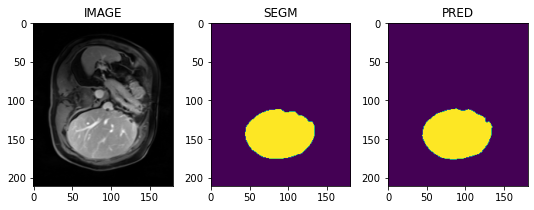

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E103814356_T1_DEL_REG_segm.nii.gz
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.9416794776916504
25.317977802344327
4.046436065200672
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.9521247744560242
2.8284271247461903
0.8260769755210511
torch.Size([1, 2, 170, 144, 150])
torch.Size([1, 170, 144, 150])


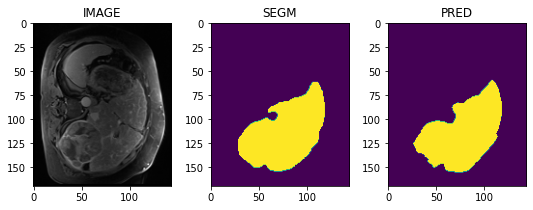

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/11022925_T1_DEL_REG_segm.nii.gz
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.8702182769775391
91.73521643200856
35.205339439702264
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.9686156511306763
1.4142135623730951
0.5335869722472527
torch.Size([1, 2, 206, 206, 110])
torch.Size([1, 206, 206, 110])


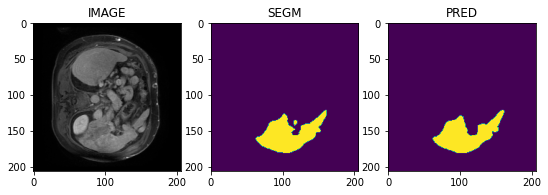

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E106533478_T1_DEL_REG_segm.nii.gz
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.965507447719574
1.4142135623730951
0.5307483205476563
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.965507447719574
1.4142135623730951
0.5307483205476563
torch.Size([1, 2, 191, 143, 132])
torch.Size([1, 191, 143, 132])


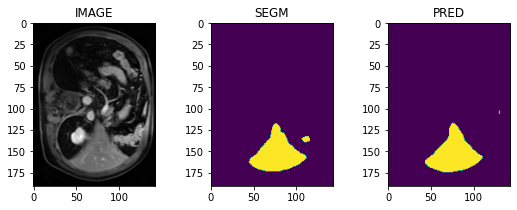

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E106851724_T1_DEL_REG_segm.nii.gz
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.8393287062644958
57.82732917920384
12.368046222460347
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.9475021362304688
3.0
0.9066754048951372
torch.Size([1, 2, 181, 181, 135])
torch.Size([1, 181, 181, 135])


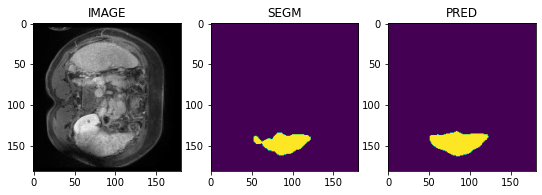

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E103511968_T1_DEL_REG_segm.nii.gz
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.957081139087677
57.175169435691224
6.014765834236495
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.9720407128334045
1.4142135623730951
0.47539843061888326
torch.Size([1, 2, 215, 173, 120])
torch.Size([1, 215, 173, 120])


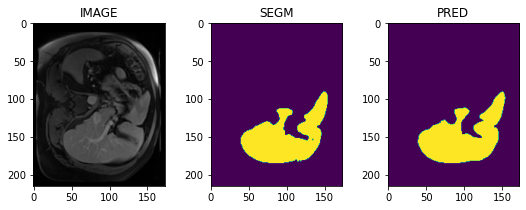

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E107553107_T1_DEL_REG_segm.nii.gz
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.9167356491088867
75.40557008603542
23.20160389435857
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.9667418003082275
2.0
0.46753169346216344
torch.Size([1, 2, 201, 151, 111])
torch.Size([1, 201, 151, 111])


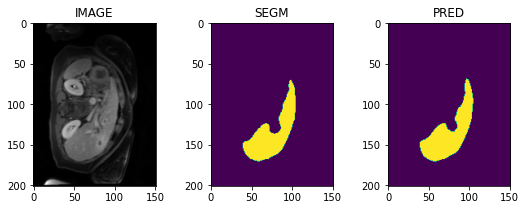

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E100588448_T1_DEL_REG_segm.nii.gz
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.9669312834739685
2.23606797749979
1.7235336966910575
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.9680867791175842
2.23606797749979
0.6395058327289567
torch.Size([1, 2, 236, 232, 120])
torch.Size([1, 236, 232, 120])


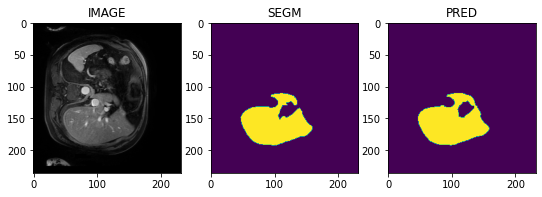

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E104134228_T1_DEL_REG_segm.nii.gz
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.8372007608413696
102.22988799203337
41.75943060468116
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.9510120153427124
5.0990195135927845
1.1156299219121952
torch.Size([1, 2, 211, 211, 110])
torch.Size([1, 211, 211, 110])


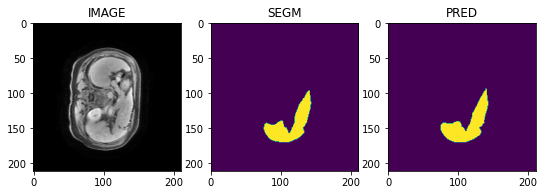

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E101686218_T1_DEL_REG_segm.nii.gz
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9619989395141602
63.85334751212332
5.163297203859806
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9657042026519775
2.8284271247461903
0.6201870760446683
torch.Size([1, 2, 210, 181, 108])
torch.Size([1, 210, 181, 108])


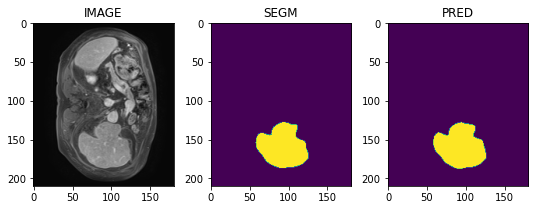

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E100967188_T1_DEL_REG_segm.nii.gz
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.9654201865196228
33.14362598003167
3.9454330503624493
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.9733211398124695
1.4142135623730951
0.5490032426544424
torch.Size([1, 2, 225, 181, 131])
torch.Size([1, 225, 181, 131])


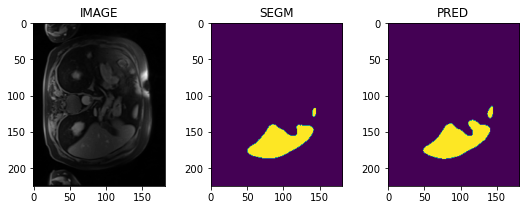

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E107476766_T1_DEL_REG_segm.nii.gz
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.9203717708587646
24.886725399060992
3.9766556869293503
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.9267509579658508
3.7416573867739413
0.8738946220728064
torch.Size([1, 2, 200, 161, 115])
torch.Size([1, 200, 161, 115])


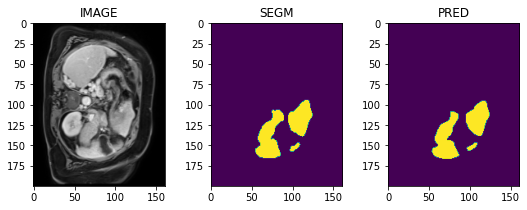

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E104250009_T1_DEL_REG_segm.nii.gz
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.9730778932571411
1.7320508075688772
1.9460972677030821
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.9748984575271606
1.4142135623730951
0.45632802148974594
torch.Size([1, 2, 200, 156, 132])
torch.Size([1, 200, 156, 132])


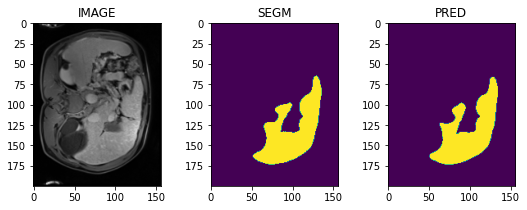

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E105152299_T1_DEL_REG_segm.nii.gz
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.8585870862007141
70.96196141752596
14.586814945935467
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.9593846797943115
1.7320508075688772
0.612416857025953
torch.Size([1, 2, 192, 192, 108])
torch.Size([1, 192, 192, 108])


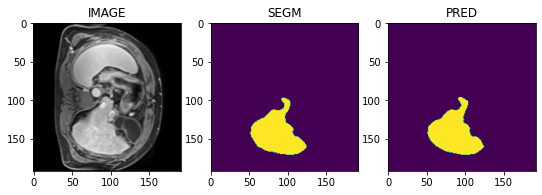

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/11308203_T1_DEL_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9729139804840088
1.7320508075688772
1.3983952833687239
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9742405414581299
1.4142135623730951
0.4947113743677595
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


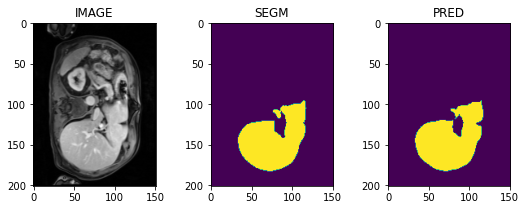

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E107046127_T1_DEL_REG_segm.nii.gz
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9537883400917053
4.47213595499958
2.695203571042606
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9580262899398804
2.23606797749979
0.5703694177287445
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])


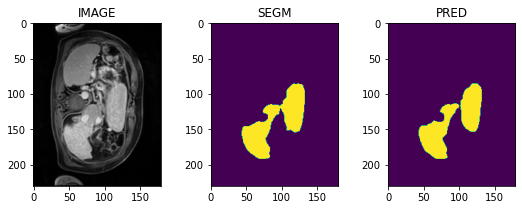

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/13106408_T1_DEL_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9635424017906189
1.4142135623730951
2.3502581215751253
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9667317271232605
1.4142135623730951
0.46368893128653027
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


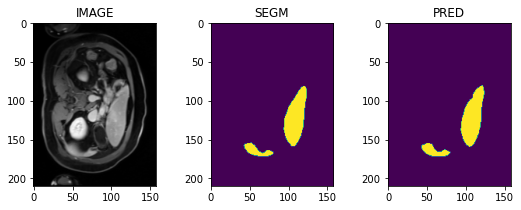

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E102486953_T1_DEL_REG_segm.nii.gz
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.8120819330215454
57.5065213693195
13.55544138881873
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.9289795756340027
5.0
0.8368359547455563
torch.Size([1, 2, 170, 149, 120])
torch.Size([1, 170, 149, 120])


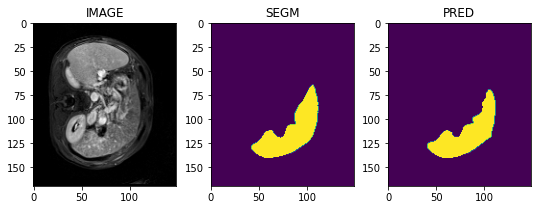

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E101055640_T1_DEL_REG_segm.nii.gz
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.9531651735305786
9.273618495495704
0.6311533246569538
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.9531651735305786
9.273618495495704
0.6311533246569538
torch.Size([1, 2, 200, 137, 120])
torch.Size([1, 200, 137, 120])


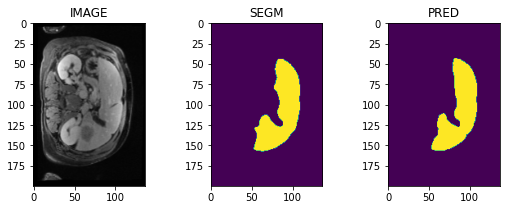

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/10807315_T1_DEL_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9547845721244812
40.86685663926091
4.547840638049729
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9713404178619385
1.4142135623730951
0.4669016080098191
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


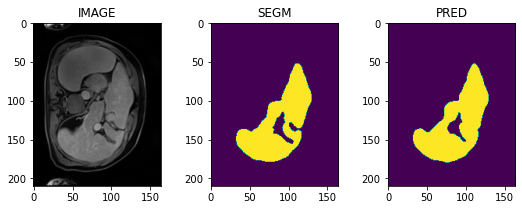

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/13170972_T1_DEL_REG_segm.nii.gz
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.8499357104301453
76.2102355330306
16.81309002286218
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.8499710559844971
76.21810803945951
16.787175514413313
torch.Size([1, 2, 205, 154, 155])
torch.Size([1, 205, 154, 155])


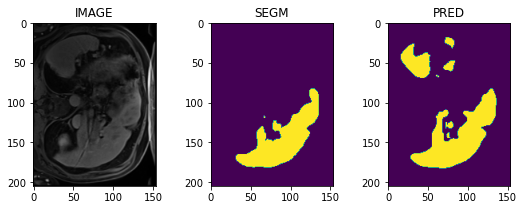

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E104594843_T1_DEL_REG_segm.nii.gz
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9626355171203613
57.761577602039594
4.703000680231165
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9720842838287354
2.0
0.5530060277265912
torch.Size([1, 2, 231, 231, 144])
torch.Size([1, 231, 231, 144])


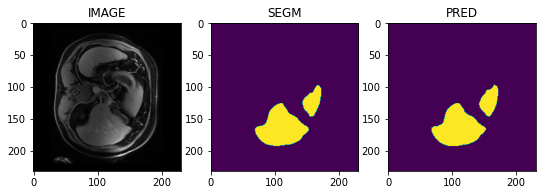

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E104034609_T1_DEL_REG_segm.nii.gz
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.9685490727424622
1.4142135623730951
0.5558399470272223
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.9685490727424622
1.4142135623730951
0.5558399470272223
torch.Size([1, 2, 191, 141, 120])
torch.Size([1, 191, 141, 120])


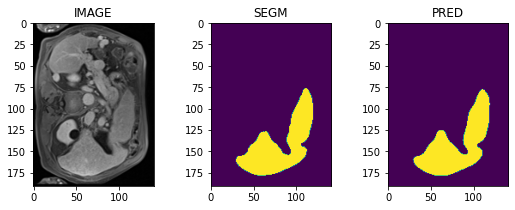

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E107774979_T1_DEL_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9683638215065002
1.4142135623730951
0.4756818632630689
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9683638215065002
1.4142135623730951
0.4756818632630689
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


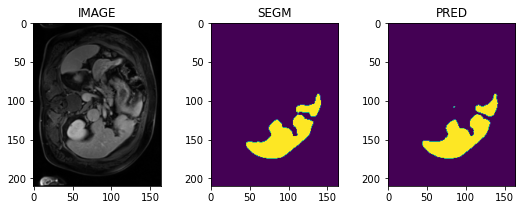

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E104900599_T1_DEL_REG_segm.nii.gz
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9388194680213928
58.221987352417685
7.92411219662435
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9676103591918945
1.7320508075688772
0.5384689500367713
torch.Size([1, 2, 230, 180, 142])
torch.Size([1, 230, 180, 142])


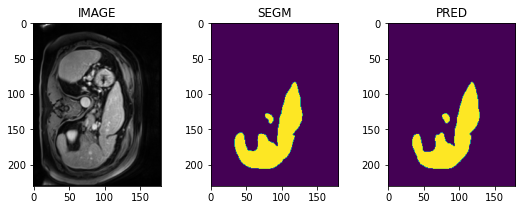

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E104657225_T1_DEL_REG_segm.nii.gz
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.9562927484512329
3.605551275463989
3.104452957178515
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.959524929523468
2.23606797749979
0.7162813735535073
torch.Size([1, 2, 180, 135, 108])
torch.Size([1, 180, 135, 108])


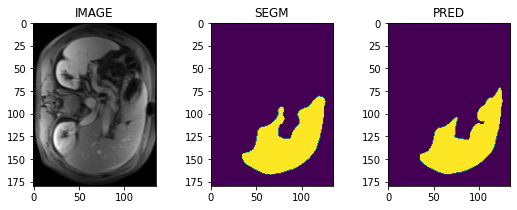

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E105599954_T1_DEL_REG_segm.nii.gz
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.9337710738182068
53.01791991336732
5.761085776718682
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.9482913017272949
3.1622776601683795
0.9862733018878584
torch.Size([1, 2, 235, 183, 132])
torch.Size([1, 235, 183, 132])


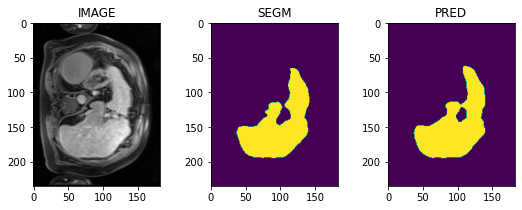

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E103570649_T1_DEL_REG_segm.nii.gz
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9597594738006592
3.0
1.720022312777008
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9622775912284851
2.0
0.6105034222555709
torch.Size([1, 2, 200, 156, 127])
torch.Size([1, 200, 156, 127])


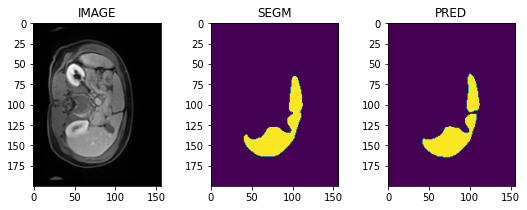

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E105504009_T1_DEL_REG_segm.nii.gz
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.9608826041221619
2.0
1.189362768185066
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.9622334241867065
2.0
0.6497353915760682
torch.Size([1, 2, 211, 152, 104])
torch.Size([1, 211, 152, 104])


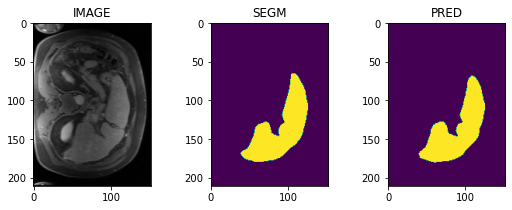

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E103831361_T1_DEL_REG_segm.nii.gz
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.872709333896637
87.09793337637073
31.71362831864168
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.9599353075027466
2.0
0.719335672809432
torch.Size([1, 2, 221, 221, 119])
torch.Size([1, 221, 221, 119])


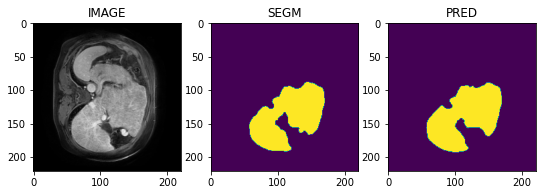

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/10843891_T1_DEL_REG_segm.nii.gz
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.9391263127326965
3.0
1.11356650664224
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.9392212629318237
3.0
1.0422048185948796
torch.Size([1, 2, 175, 137, 120])
torch.Size([1, 175, 137, 120])


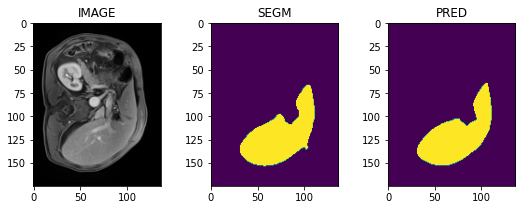

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E101762106_T1_DEL_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.8688362240791321
84.17244204607586
18.107777455350767
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9575027823448181
2.23606797749979
0.6671844495024551
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


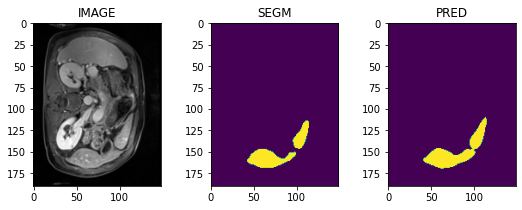

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/12543786_T1_DEL_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9324584007263184
43.87482193696061
5.236598115032265
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9531543254852295
2.23606797749979
0.7863044752427493
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


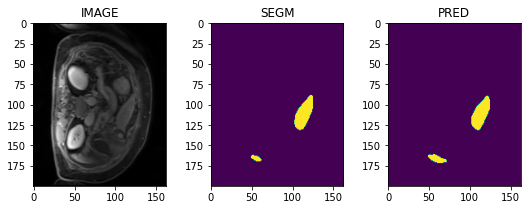

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E107077373_T1_DEL_REG_segm.nii.gz
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.9702538251876831
1.4142135623730951
0.4914306983945101
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.9702538251876831
1.4142135623730951
0.4914306983945101
torch.Size([1, 2, 220, 172, 120])
torch.Size([1, 220, 172, 120])


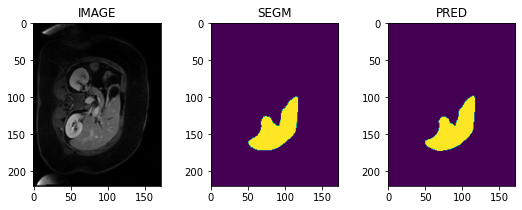

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/DEL-NET/E106501028_T1_DEL_REG_segm.nii.gz
[0.9640887379646301, 0.965739369392395, 0.9623621106147766, 0.9572579264640808, 0.937119722366333, 0.9563689231872559, 0.866807222366333, 0.9740873575210571, 0.932924211025238, 0.8521625399589539, 0.9424685835838318, 0.9603230953216553, 0.9266389608383179, 0.8814475536346436, 0.9595425724983215, 0.9643584489822388, 0.9594059586524963, 0.975307285785675, 0.9500724077224731, 0.913772702217102, 0.922187089920044, 0.9684295058250427, 0.8523504137992859, 0.854293167591095, 0.8686594367027283, 0.924512505531311, 0.9642710089683533, 0.9502758383750916, 0.9593794345855713, 0.9775063991546631, 0.9660359621047974, 0.9465732574462891, 0.914948582649231, 0.9594775438308716, 0.9775977730751038, 0.968567430973053, 0.9710635542869568, 0.9630009531974792, 0.9505160450935364, 0.9690290689468384, 0.9483677744865417, 0.9619626402854919, 0.7345492839813232, 0.9512888789176941, 0.9083037

DICE  POST_DICE       HD95  POST_HD95  InferenceTime  \
0  0.964089   0.964098   1.414214   1.414214       0.025142   
1  0.965739   0.975605  51.022540   1.414214       0.008609   
2  0.962362   0.968238  31.890437   1.414214       0.013735   
3  0.957258   0.970132  42.343831   1.414214       0.015174   
4  0.937120   0.961385  63.663176   2.236068       0.008877   

                                AUTOMATED-LIVER-SEGM         EXPERIMENT_ID  
0  /tensor5/data1/mgross/Liver/studies/Contrast-N...  DEL-Contrast-Imaging  
1  /tensor5/data1/mgross/Liver/studies/Contrast-N...  DEL-Contrast-Imaging  
2  /tensor5/data1/mgross/Liver/studies/Contrast-N...  DEL-Contrast-Imaging  
3  /tensor5/data1/mgross/Liver/studies/Contrast-N...  DEL-Contrast-Imaging  
4  /tensor5/data1/mgross/Liver/studies/Contrast-N...  DEL-Contrast-Imaging

In [33]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
        output_path= OUTPUT_PATH)
    #,max_eval = 2)

torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = 'DEL-Contrast-Imaging'
df_test_results.head()

In [41]:
for i in [df_test_results]:
    for idx, row in  i.iterrows():
            i.loc[idx, 'ACCESSION_ID'] = str(row['AUTOMATED-LIVER-SEGM'].split('/')[-1].split('_')[-5])


In [42]:
df_test_results.to_csv('Results/Results-DEL-Net.csv')

## External Testing

In [27]:
import glob 
import pandas as pd

external_testing_img_paths = pd.read_csv('/tensor5/data1/jonofrey/Liver/Paris/registration/nonrigid_nmi/Nonrigid_Registered_NMI_Image_Paths.csv')

included_accs = [1,3, 4, 6, 10, 11, 12, 17, 18, 19, 22, 32, 35, 40, 55, 59]
external_testing_img_paths = external_testing_img_paths[external_testing_img_paths['ACCESSION_ID'].isin(included_accs)]

segm_path = '/tensor5/data1/mgross/Liver/Paris/man_liver_segms/*_PV_LIVER-label.nii.gz'
segm_paths = glob.glob(segm_path)

external_testing_accs = [int(i.split('/')[-1].split('_')[0]) for i in segm_paths]

df_external_testing = pd.DataFrame({'ACCESSION_ID': external_testing_accs, 'SEGM' : segm_paths})
df_external_testing = pd.merge(external_testing_img_paths, df_external_testing, on = 'ACCESSION_ID')

df_external_testing = df_external_testing[['ACCESSION_ID','PV_PRE','PV_ART','PV','PV_DEL',  'SEGM']]



df_external_testing.rename(columns={'PV_DEL' : 'IMAGE', 'LIVER': 'SEGM'}, inplace = True)
df_external_testing

ACCESSION_ID                                             PV_PRE  \
0              1  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1              3  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
2              4  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
3              6  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
4             10  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
5             11  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
6             12  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
7             17  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
8             18  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
9             19  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
10            22  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
11            32  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
12            35  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
13            40  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
14            55  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
15            59  /tensor5/data1/jonofrey/Liver/Paris/registrati...   

                                               PV_ART  \
0   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
2   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
3   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
4   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
5   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
6   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
7   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
8   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
9   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
10  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
11  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
12  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
13  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
14  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
15  /tensor5/data1/jonofrey/Liver/Paris/registrati...   

                                                   PV  \
0   /tensor5/data1/mgross/Liver/Paris/00001/00001_...   
1   /tensor5/data1/mgross/Liver/Paris/00003/00003_...   
2   /tensor5/data1/mgross/Liver/Paris/00004/00004_...   
3   /tensor5/data1/mgross/Liver/Paris/00006/00006_...   
4   /tensor5/data1/mgross/Liver/Paris/00010/00010_...   
5   /tensor5/data1/mgross/Liver/Paris/00011/00011_...   
6   /tensor5/data1/mgross/Liver/Paris/00012/00012_...   
7   /tensor5/data1/mgross/Liver/Paris/00017/00017_...   
8   /tensor5/data1/mgross/Liver/Paris/00018/00018_...   
9   /tensor5/data1/mgross/Liver/Paris/00019/00019_...   
10  /tensor5/data1/mgross/Liver/Paris/00022/00022_...   
11  /tensor5/data1/mgross/Liver/Paris/00032/00032_...   
12  /tensor5/data1/mgross/Liver/Paris/00035/00035_...   
13  /tensor5/data1/mgross/Liver/Paris/00040/00040_...   
14  /tensor5/data1/mgross/Liver/Paris/00055/00055_...   
15  /tensor5/data1/mgross/Liver/Paris/00059/00059_...   

                                                IMAGE  \
0   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
2   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
3   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
4   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
5   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
6   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
7   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
8   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
9   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
10  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
11  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
12  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
13  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1

In [28]:
external_test_data_dict = df_external_testing.to_dict('records')
print('Number of external testing files: ', len(external_test_data_dict))

Number of external testing files:  16


In [29]:
external_test_ds = monai.data.PersistentDataset(
    data=external_test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

torch.Size([1, 1, 230, 230, 125])
image shape: torch.Size([230, 230, 125]), label shape: torch.Size([230, 230, 125])
image mean: 0.3483874201774597


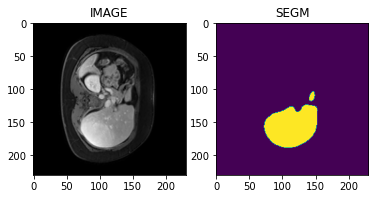

In [30]:
check_ds = monai.data.Dataset(data=external_test_data_dict[1:2], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image, label = (check_data['IMAGE'][i][0], check_data['SEGM'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//2
    
    plt.figure('check', (6, 3))
    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.show()

0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarni

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 181 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 182 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 182 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Use

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the 

0.9214963912963867
4.134655400434044
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


0.9219419956207275
3.5169300332438977
inf
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


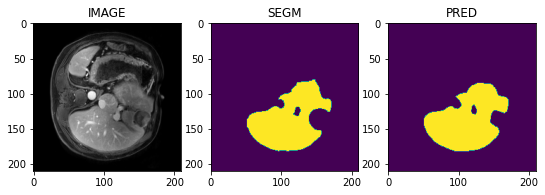

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 61 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 62 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 63 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 209 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 209 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 210 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 61 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 62 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 63 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarnin

0.959109902381897
2.269484368381676
inf
0.9591264724731445
2.269484368381676
inf
torch.Size([1, 2, 230, 230, 125])
torch.Size([1, 230, 230, 125])


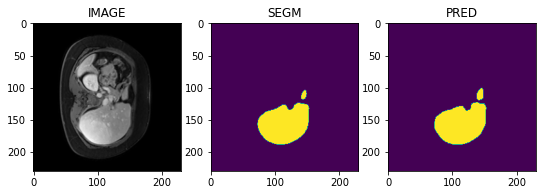

0.9553550481796265
3.0124774645783536
inf
0.9554089903831482
2.367213147397737
inf
torch.Size([1, 2, 228, 228, 105])
torch.Size([1, 228, 228, 105])


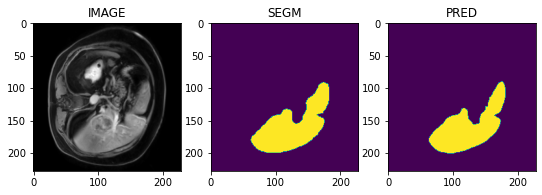

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 80 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarnin

0.9616268873214722
2.2966781855127807
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 176 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 177 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 178 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning

0.9621783494949341
1.4508201055868004
inf
torch.Size([1, 2, 211, 211, 104])
torch.Size([1, 211, 211, 104])


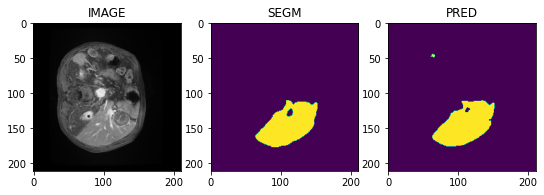

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 172 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 173 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 174 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161:

0.891183614730835
36.380060515388095
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 172 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 173 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning

0.9018239378929138
5.405527176198147
inf
torch.Size([1, 2, 191, 167, 118])
torch.Size([1, 191, 167, 118])


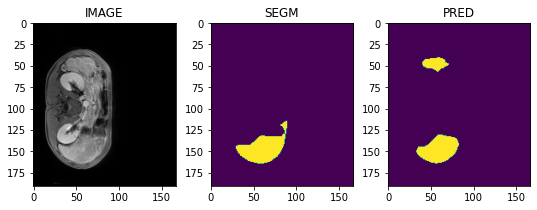

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


0.9462602734565735
7.032125343637715
inf
0.9498337507247925
4.444681102581568
inf
torch.Size([1, 2, 211, 211, 109])
torch.Size([1, 211, 211, 109])


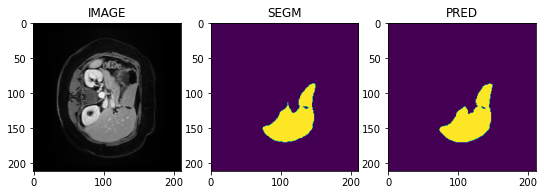

0.905863344669342
3.03519825144416
inf
0.9058849811553955
3.031352097598006
inf
torch.Size([1, 2, 201, 178, 108])
torch.Size([1, 201, 178, 108])


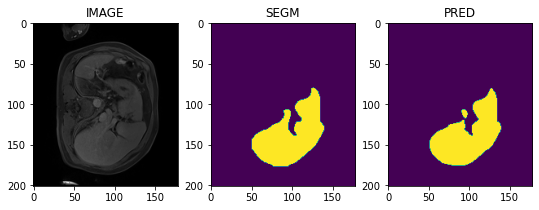

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 89 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 90 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 91 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarnin

0.94248366355896
2.708960477626145
inf
0.9425211548805237
2.696315732221861
inf
torch.Size([1, 2, 204, 204, 100])
torch.Size([1, 204, 204, 100])


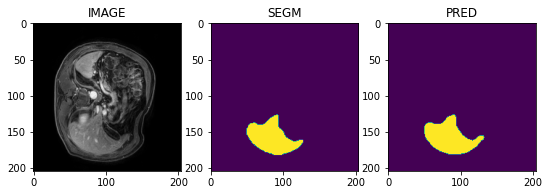

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Use

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning

0.814251720905304
20.836560933189926
inf
0.8499686121940613
7.0541896803443755
inf
torch.Size([1, 2, 189, 189, 105])
torch.Size([1, 189, 189, 105])


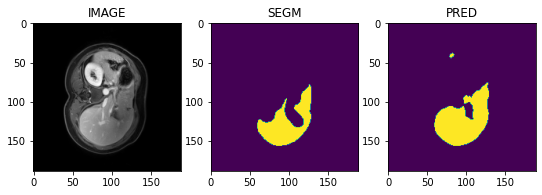

0.9416987895965576
7.100748495164604
inf
0.9488979578018188
2.1410379428779756
0.4571695241527945
torch.Size([1, 2, 201, 201, 96])
torch.Size([1, 201, 201, 96])


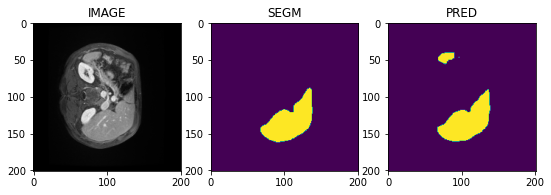

0.9560489654541016
3.0440477010871305
inf
0.9562294483184814
2.06569841879048
inf
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


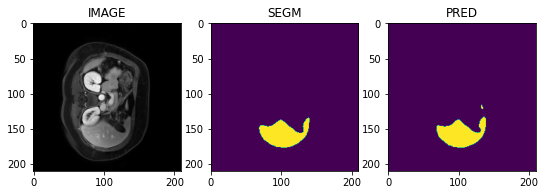

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


0.9405688047409058
42.714753497045464
inf
0.9562299847602844
1.6678602435907932
inf
torch.Size([1, 2, 210, 210, 110])
torch.Size([1, 210, 210, 110])


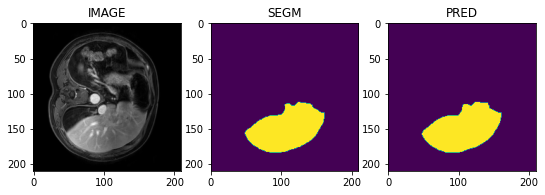

0.9602320790290833
3.5930335761047
inf
0.9602649211883545
3.5930335761047
inf
torch.Size([1, 2, 210, 210, 125])
torch.Size([1, 210, 210, 125])


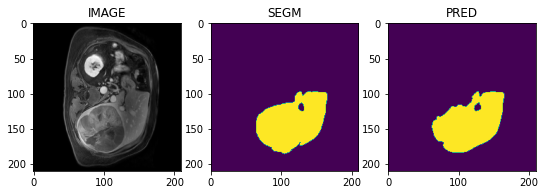

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 135 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 135 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning

0.9580819010734558
2.9237945551395237
inf
0.9580819010734558
2.9237945551395237
inf
torch.Size([1, 2, 172, 172, 100])
torch.Size([1, 172, 172, 100])


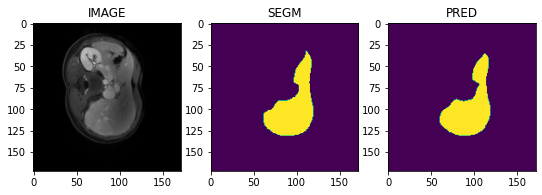

0.9661725163459778
4.243056876056924
inf
0.9681588411331177
1.7043068760569267
inf
torch.Size([1, 2, 221, 221, 114])
torch.Size([1, 221, 221, 114])


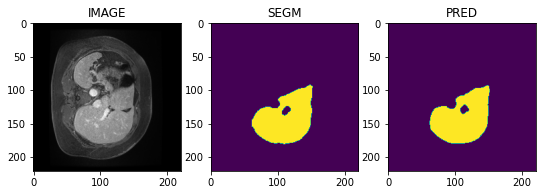

0.941421627998352
2.0670685910600746
inf
0.941422700881958
2.0670685910600746
inf
torch.Size([1, 2, 207, 207, 105])
torch.Size([1, 207, 207, 105])


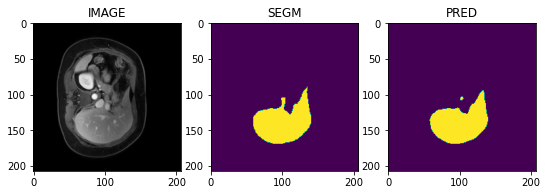

[0.9214963912963867, 0.959109902381897, 0.9553550481796265, 0.9616268873214722, 0.891183614730835, 0.9462602734565735, 0.905863344669342, 0.94248366355896, 0.814251720905304, 0.9416987895965576, 0.9560489654541016, 0.9405688047409058, 0.9602320790290833, 0.9580819010734558, 0.9661725163459778, 0.941421627998352]


DICE  POST_DICE       HD95  POST_HD95  InferenceTime
count  16.000000  16.000000  16.000000  16.000000      16.000000
mean    0.935116   0.939873   9.212044   3.024957       0.007416
std     0.038401   0.030973  12.729106   1.511878       0.005125
min     0.814252   0.849969   2.067069   1.450820       0.003496
25%     0.935801   0.936553   2.870086   2.066726       0.004598
50%     0.944372   0.952621   3.318541   2.531764       0.005824
75%     0.958339   0.958343   7.049281   3.535956       0.007903
max     0.966173   0.968159  42.714753   7.054190       0.024506

In [31]:
roi_size = (224, 224, 128)

df_external_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= external_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=False) #, max_eval = 2

torch.cuda.empty_cache()
df_external_test_results['EXPERIMENT_ID'] = 'DEL-Contrast-Imaging'
df_external_test_results.describe()

In [32]:
df_external_test_results.describe()

DICE  POST_DICE       HD95  POST_HD95  InferenceTime
count  16.000000  16.000000  16.000000  16.000000      16.000000
mean    0.935116   0.939873   9.212044   3.024957       0.007416
std     0.038401   0.030973  12.729106   1.511878       0.005125
min     0.814252   0.849969   2.067069   1.450820       0.003496
25%     0.935801   0.936553   2.870086   2.066726       0.004598
50%     0.944372   0.952621   3.318541   2.531764       0.005824
75%     0.958339   0.958343   7.049281   3.535956       0.007903
max     0.966173   0.968159  42.714753   7.054190       0.024506

In [33]:
df_external_test_results.to_csv('ExternalTestingResults/Results-DEL-Net.csv')